In [13]:
% matplotlib inline

import math

import numpy as np

from scipy.ndimage.morphology import distance_transform_cdt as distance
from scipy.ndimage.morphology import binary_fill_holes as fill_holes
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import splprep, splev, bisplev, interp1d
from scipy.optimize import minimize

from skimage import feature, filters, morphology
from skimage.external import tifffile
from skimage.feature import canny
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import binary_closing as close
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_opening as open
from skimage.filters import gaussian

import matplotlib.pyplot as plt

from helpers import intersection

import cv2

from IPython.core.debugger import set_trace

In [2]:
im_410 = tifffile.imread('../data/raw_data_1/all_410_big.tif')
im_470 = tifffile.imread('../data/raw_data_1/all_470_big.tif')
im_410_bin = im_410.copy()
for i in range(len(im_410)):
    E = filters.sobel(im_410[i])
    T = 0.01
    E[E<T] = 0
    E[E>T] = 255
    E = dilate(dilate(E))
    E = fill_holes(E)
    E = close(close(E))
    E = fill_holes(E)
    E = erode(erode(E))
    
    im_410_bin[i] = E
tifffile.imsave('../data/raw_data_1/thresh_410.tif', im_410)

In [233]:
def com(img):
    n = img.shape[0]
    i = np.arange(n).reshape([n, 1])
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.sum(img * i, axis=0) / np.sum(img, axis=0)

def com_nonnan(img):
    x = np.arange(img.shape[1])
    y = com(img)
    s = np.dstack((x,y))
    return s[np.invert(np.isnan(s[:,:,1]))]

def get_medial_spline(img, k=3, smoothness=0):
    I = img.copy()
    medial_line = com_nonnan(I)
    
    padL = 5
    padR = 2
    return spline(medial_line[:,0][padL:-padR], medial_line[:,1][padL:-padR], k=k, s=smoothness)

def get_ctrl_pts(border_pts, spl, padding=10, n_points=10):
    """
    returns result=[x,y]
    x: result[0]
    y: result[1]
    """
    border_x = border_pts[0]
    left_bound, right_bound = np.min(border_x), np.max(border_x)
    
    ctrl_x = np.linspace(left_bound-padding, right_bound+padding, n_points)
    ctrl_y = spl(ctrl_x)
    return np.asarray([ctrl_x, ctrl_y])

def get_border_pts(img, n_points=1000, smoothness=10):
    """Expects a THRESHOLDED (BINARY) image
    
    returns result=[x, y]:
    x: result[0]
    y: result[1]
    """
    (_, contours, _) = cv2.findContours(img.astype(np.uint8) * 255, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour_xs = contours[0][:,0,0]
    contour_ys = contours[0][:,0,1]
    
    tck, u = splprep([contour_xs, contour_ys], s=smoothness, per=True)
    x, y = splev(np.linspace(0, 1, n_points), tck)
    
    return [x, y]

def normal_intersect(spl, border_pts, x):
    der = spl.derivative()
    point = [x, spl(x)]
    m = -1/der(x)
    
    b = spl(x) - (m * x)
    
    @np.vectorize
    def normal_y(x):
        return math.floor(m*x + b)
    
    xs_norm = np.linspace(point[0]-10, point[0]+10, 50)
    ys_norm = normal_y(xs_norm)
    
    return intersection(border_pts[0], border_pts[1], xs_norm, ys_norm)

def get_normal_pts(spl, x, padding=10):
    der = spl.derivative()
    point = [x, spl(x)]
    m = -1/der(x)
    
    b = spl(x) - (m * x)
    
    @np.vectorize
    def normal_y(x):
        return math.floor(m*x + b)
    
    xs_norm = np.linspace(point[0]-padding, point[0]+padding, 50)
    ys_norm = normal_y(xs_norm)
    return [xs_norm, ys_norm]

/Users/sean/.virtualenvs/wormAnalysis/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][117]=x[0][0]
  (i, m, i)))


0.4448980300238616

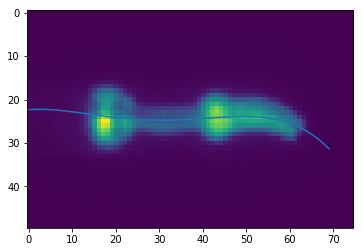

In [237]:
idx = 501
xi = 30

N_CTRL_PTS = 6

IMG = im_410_bin[idx]


plt.imshow(im_470[idx])

border_pts = get_border_pts(IMG)
# plt.scatter(border_pts[0], border_pts[1])

coms = com_nonnan(IMG)
# plt.scatter(coms[:,0], coms[:,1])

med_spl = get_medial_spline(IMG, k=4, smoothness=1000)
med_spl_der = med_spl.derivative()
plt.plot(np.arange(70), np.clip(med_spl(np.arange(70)), 0, 40))

# ctrl_pts = get_ctrl_pts(border_pts, med_spl, padding=-3, n_points=N_CTRL_PTS)
# plt.plot(ctrl_pts[0], ctrl_pts[1], 'o-', color='orange')

normal_pts = get_normal_pts(med_spl, xi, padding=3)
# plt.plot(normal_pts[0], np.clip(normal_pts[1], 0, 40))


# plt.scatter(min_ctrl[0], min_ctrl[1])
# min_spl = spline(min_ctrl[0], min_ctrl[1], k=4)
# plt.plot(np.linspace(0,70), np.clip(min_spl(np.linspace(0,70)), 0, 45))


intersections = normal_intersect(med_spl, border_pts, xi)
i0_x, i1_x = intersections[0][0], intersections[0][1]
i0_y, i1_y = intersections[1][0], intersections[1][1]

midline_x, midline_y = xi, med_spl(xi)

np.square(dist(midline_x, midline_y, i0_x, i0_y) - dist(midline_x, midline_y, i1_x, i1_y))

In [189]:
def cost(ctrl_pts):
    """
    border_pts: [xs, ys]
    ctrl_pts: [xs ys]
    """
    ctrl_pts = np.reshape(ctrl_pts, (2,N_CTRL_PTS))
    spl = spline(ctrl_pts[0], ctrl_pts[1], k=5, s=2)
    
    border_xs, border_ys = border_pts[0].astype(np.int), border_pts[1].astype(np.int)
    
    bounds = (np.min(border_xs.ravel()), np.max(border_xs.ravel()))
    
    total_cost = 0
    
#     set_trace()
    
    for xi in range(bounds[0], bounds[1]):
        intersections = normal_intersect(spl, border_pts, xi)
        
        if len(intersections[0]) != 2:
            continue
        else:
            i0_x, i1_x = intersections[0][0], intersections[0][1]
            i0_y, i1_y = intersections[1][0], intersections[1][1]

            midline_x, midline_y = xi, spl(xi)

            cost_xi = np.square(dist(midline_x, midline_y, i0_x, i0_y) - dist(midline_x, midline_y, i1_x, i1_y))
            total_cost += cost_xi
    
    return total_cost


def dist(x0, y0, x1, y1):
    return math.sqrt(((x0-x1)**2) + ((y0-y1)**2))

In [191]:
def printstate(xk):
    print(xk)
    print(cost(xk))
    print("----")

In [192]:
result = minimize(cost, ctrl_pts.ravel(), method='Nelder-Mead', callback=printstate)
result

[20.71786295 23.50265709 26.28745124 29.07224539 31.85703953 34.64183368
 37.42662782 40.21142197 42.99621612 45.78101026 48.56580441 51.35059855
 54.1353927  56.92018685 20.57525347 21.33584746 22.40176881 23.22522724
 28.32388088 30.40289493 28.5881115  28.05189532 27.68359413 26.3484121
 23.97381533 22.18462648 18.58941052 16.91302237]
198.01294922031752
----
[20.71786295 23.50265709 26.28745124 29.07224539 31.85703953 34.64183368
 37.42662782 40.21142197 42.99621612 45.78101026 48.56580441 51.35059855
 54.1353927  56.92018685 20.57525347 21.33584746 22.40176881 23.22522724
 28.32388088 30.40289493 28.5881115  28.05189532 27.68359413 26.3484121
 23.97381533 22.18462648 18.58941052 16.91302237]
198.01294922031752
----
[20.71786295 23.50265709 26.28745124 29.07224539 31.85703953 34.64183368
 37.42662782 40.21142197 42.99621612 45.78101026 48.56580441 51.35059855
 54.1353927  56.92018685 20.57525347 21.33584746 22.40176881 23.22522724
 28.32388088 30.40289493 28.5881115  28.05189532 27

ValueError: x must be strictly increasing

In [140]:
min_ctrl = result.x.reshape(2,7)
min_ctrl

array([[14.94578398, 22.75773743, 30.6835419 , 38.34680591, 45.073511  ,
        53.5089781 , 61.56627039],
       [24.6068089 , 24.70793084, 24.6241577 , 24.58247508, 24.5309014 ,
        24.71969454, 25.309983  ]])